<a href="https://colab.research.google.com/github/sunnypaajee/Fake_News/blob/master/LSTM_AUTOENCODER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
df = pd.read_csv('JPM.csv', usecols =['Open' ,'Date'])
df.head()

,Date,Open
0,2000-01-03,49.833332
1,2000-01-04,47.083332
2,2000-01-05,46.833332
3,2000-01-06,46.750000
4,2000-01-07,48.416668


In [ ]:
df.isnull().sum()


Date    0
Open    0
dtype: int64

Used 23 years stock price data for JPMC from Yahoo Finance USed LSTM Autoencoding to detect anomalies




In [ ]:
df['Date']= df['Date'].apply(lambda str_date :pd.to_datetime(str_date, format='%Y-%m-%d'))
df.set_index('Date', inplace=True)

df.head()

,Open
Date,
2000-01-03,49.833332
2000-01-04,47.083332
2000-01-05,46.833332
2000-01-06,46.750000
2000-01-07,48.416668


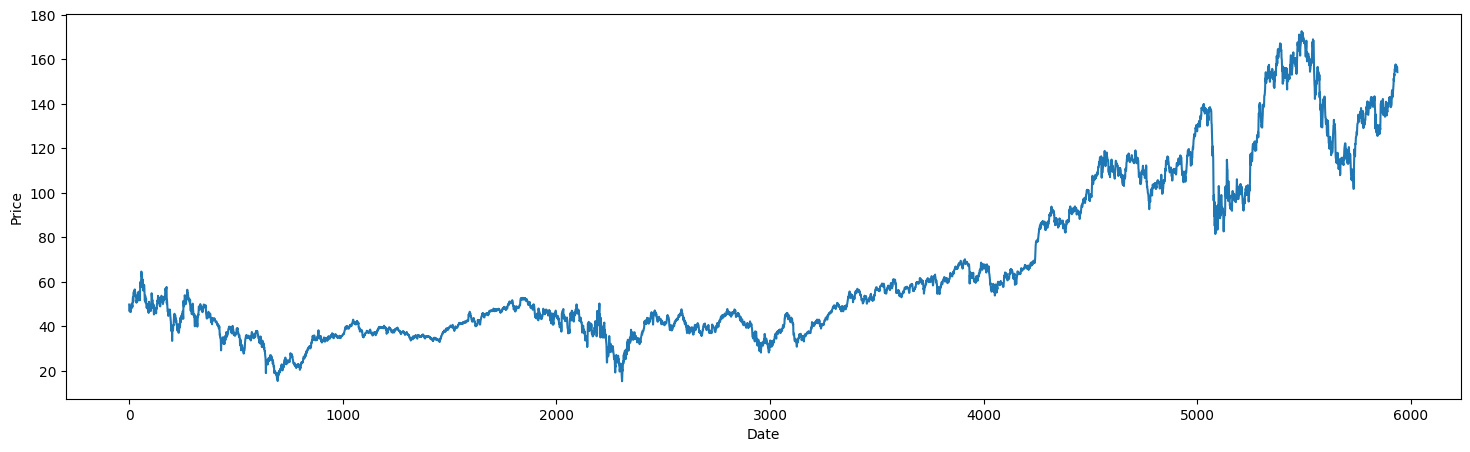

In [ ]:
fig = plt.figure(figsize=(18,5))
plt.plot(df['Open'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [ ]:
train_data = df[df.index < pd.to_datetime('01-01-2018')]
test_data = df[df.index >= pd.to_datetime('01-01-2018')]

In [ ]:
train_data.shape

(4528, 1)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))

scaler.fit(train_data)

train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [ ]:
train_data[:10]

array([[0.37125211],
       [0.34162806],
       [0.33893497],
       [0.33803728],
       [0.35599126],
       [0.35688895],
       [0.3371396 ],
       [0.33489532],
       [0.34521888],
       [0.3654171 ]])

In [ ]:
## convert data into proper format

time_steps = 60

def convert(data, time_steps):

    X = list()

    for i in range(time_steps, len(data)):

        obs = data[i-time_steps:i,0].reshape(time_steps) ## observations

        X.append(obs)

    X = np.array(X)

    X = np.reshape(X, (X.shape[0],X.shape[1],1))

    return X

In [ ]:
X_train = convert(data=train_data, time_steps=time_steps)
X_test = convert(data=test_data, time_steps=time_steps)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(4468, 60, 1)
(1349, 60, 1)


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed
from keras.optimizers import Adam


In [ ]:
model = Sequential() ## initialization

model.add(LSTM(units=3*X_train.shape[1], activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.5)) ## 30% perceptrons turned off at every pass
## output_shape --> (batch_size, 3*X_train.shape[1])
model.add(RepeatVector(n=X_train.shape[1]))
## output_shape --> (batch_size, 3*X_train.shape[1], X_train.shape[1])
model.add(LSTM(units=3*X_train.shape[1], activation='tanh', return_sequences=True))
model.add(Dropout(rate=0.5)) ## 30% perceptrons turned off at every pass
## output_shape --> (batch_size, 3*X_train.shape[1], X_train.shape[1])
model.add(TimeDistributed(Dense(units=X_train.shape[2])))
## output_shape --> (batch_size, 3*X_train.shape[1], 1) --> SAME AS INPUT (AUTOENCODER CONCEPT)

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 180)               131040    
                                                                 
 dropout (Dropout)           (None, 180)               0         
                                                                 
 repeat_vector (RepeatVecto  (None, 60, 180)           0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 60, 180)           259920    
                                                                 
 dropout_1 (Dropout)         (None, 60, 180)           0         
                                                                 
 time_distributed (TimeDist  (None, 60, 1)             181       
 ributed)                                               

In [ ]:

## training

history = model.fit(x=X_train,
                   y=X_train,
                   batch_size=64,
                   epochs=100,
                   validation_split=0.1,
                   shuffle=False)

Epoch 1/100
63/63 [==============================] - 29s 381ms/step - loss: 0.0100 - val_loss: 0.0118
Epoch 2/100
63/63 [==============================] - 22s 355ms/step - loss: 0.0048 - val_loss: 0.0163
Epoch 3/100
63/63 [==============================] - 22s 354ms/step - loss: 0.0053 - val_loss: 0.0190
Epoch 4/100
63/63 [==============================] - 24s 388ms/step - loss: 0.0060 - val_loss: 0.0195
Epoch 5/100
63/63 [==============================] - 22s 347ms/step - loss: 0.0061 - val_loss: 0.0089
Epoch 6/100
63/63 [==============================] - 25s 393ms/step - loss: 0.0067 - val_loss: 0.0085
Epoch 7/100
63/63 [==============================] - 23s 359ms/step - loss: 0.0073 - val_loss: 0.0086
Epoch 8/100
63/63 [==============================] - 22s 348ms/step - loss: 0.0075 - val_loss: 0.0093
Epoch 9/100
63/63 [==============================] - 23s 363ms/step - loss: 0.0072 - val_loss: 0.0167
Epoch 10/100
63/63 [==============================] - 22s 349ms/step - loss: 0.008

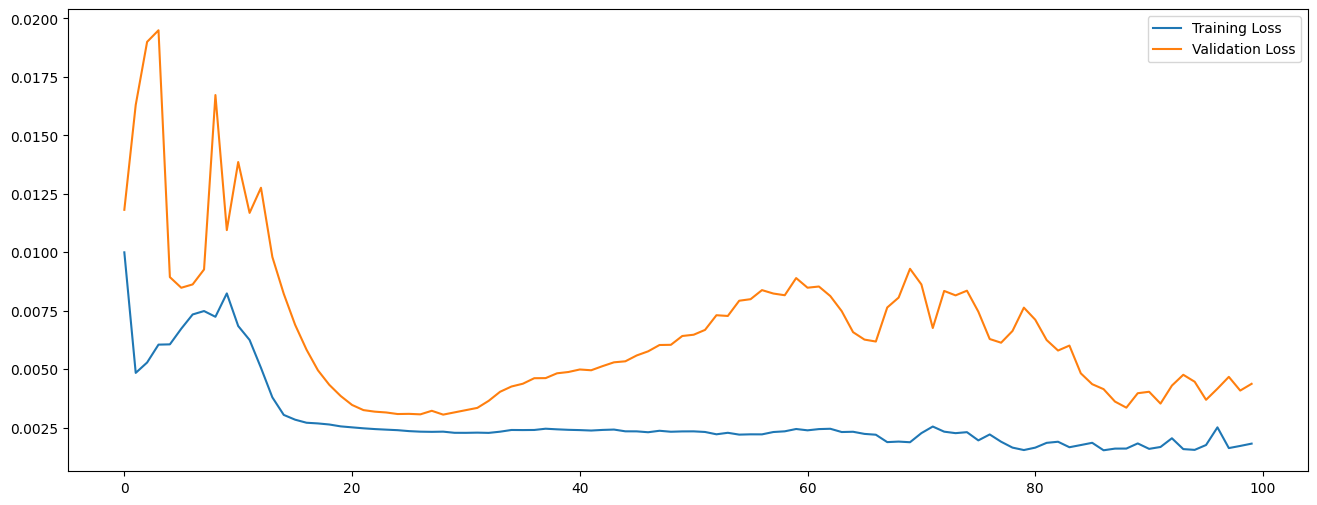

In [ ]:
fig = plt.figure(figsize=(16,6))

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

plt.show()


140/140 [==============================] - 17s 87ms/step


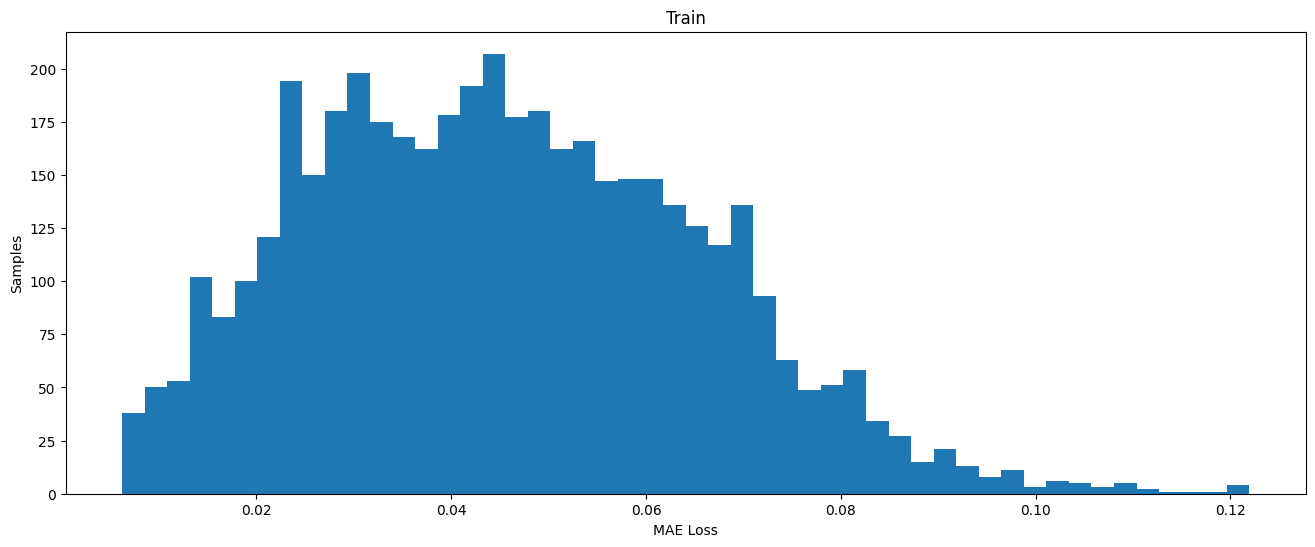

In [ ]:
train_mae_loss = np.mean(np.abs(model.predict(X_train)-X_train), axis=1)

## histogram of mean absolute error

fig = plt.figure(figsize=(16,6))

plt.hist(train_mae_loss, bins=50)
plt.title('Train')
plt.xlabel('MAE Loss')
plt.ylabel('Samples')

plt.show()

In [ ]:

threshold = np.max(train_mae_loss) ## this is the max error that our model produced while reconstructing an input
threshold


0.12193968706076372

43/43 [==============================] - 5s 104ms/step


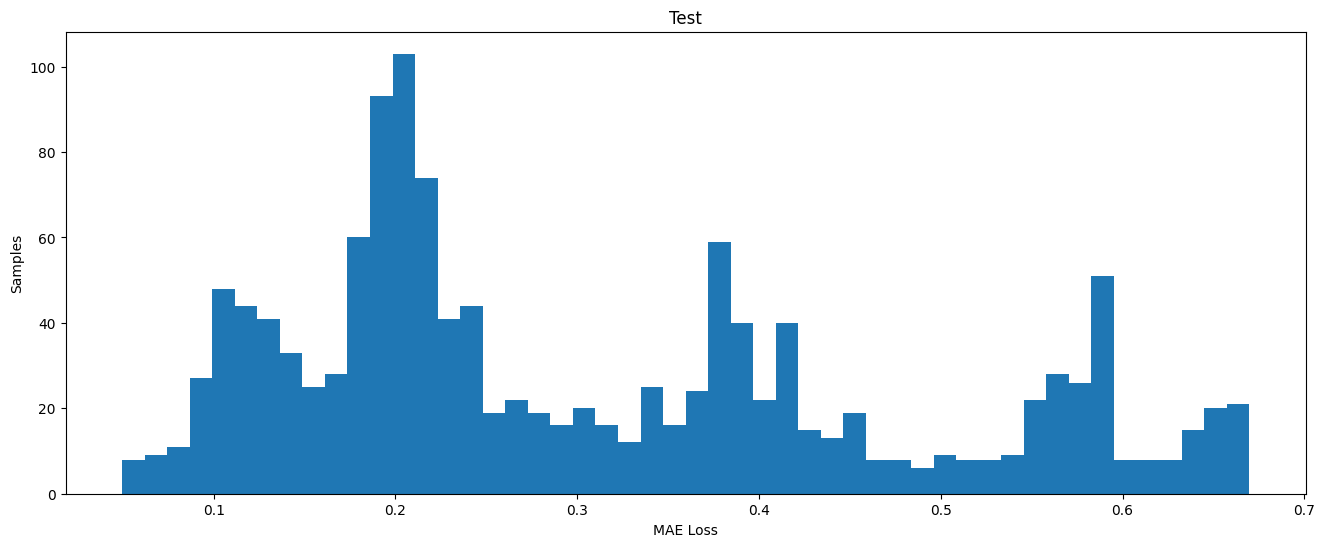

In [ ]:
test_mae_loss = np.mean(np.abs(model.predict(X_test)-X_test), axis=1)

## histogram of mean absolute error

fig = plt.figure(figsize=(16,6))

plt.hist(test_mae_loss, bins=50)
plt.title('Test')
plt.xlabel('MAE Loss')
plt.ylabel('Samples')

plt.show()

In [ ]:

anomalies = test_mae_loss > threshold

anomalous_data_indices = [] ## indices of test observations that represent anomalies

for data_idx in range(time_steps - 1, len(test_data) - time_steps + 1):

    if np.all(anomalies[data_idx - time_steps + 1 : data_idx]):

        anomalous_data_indices.append(data_idx)


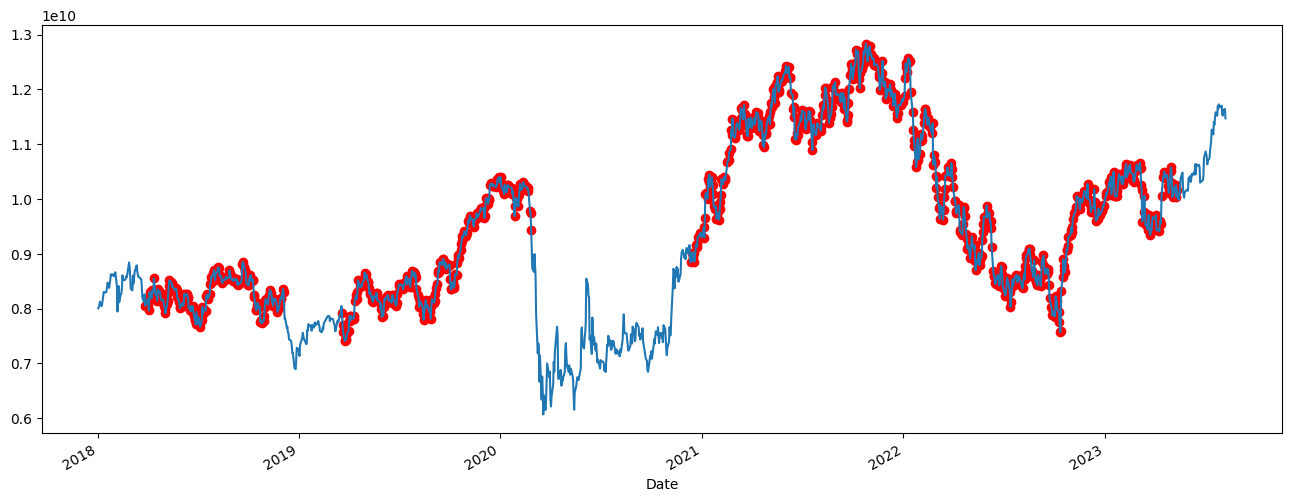

In [ ]:
test_data = scaler.inverse_transform(test_data)

reconstruct = pd.DataFrame(data=test_data, index=df.index[len(df)-len(test_data):], columns=['Open'])

test_anomalies = reconstruct.iloc[anomalous_data_indices]

fig, ax = plt.subplots(figsize=(16,6))

reconstruct.plot(legend=False, ax=ax)

ax.scatter(x=test_anomalies.index, y=test_anomalies['Open'], color="r")

plt.show()

In [ ]:
from keras.models import save_model
save_model(model, 'LSTM_Autoencoder_timesteps60_epochs100_batchsize64.h5')


<ipython-input-53-0ebfa63c16ec>:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, 'LSTM_Autoencoder_timesteps60_epochs100_batchsize64.h5')
